## Анализ воронок пользователей

###  Функции для интеграции с ClickHouse

В файле `some_funcs` есть класс `simple_ch_client` c 3 функциями
* get_clickhouse_data
* get_clickhouse_df
* upload

Сначала надо создать экземпляр класса, инициализировав его начальными параметрами - хост, пользователь, пароль и путь к сертификату

In [26]:
import some_funcs
from some_funcs import simple_ch_client

In [30]:
CH_HOST = 'https://rc1a-2k165kgnp42shxqo.mdb.yandexcloud.net:8443'
CH_USER = 'z_sergey'
CH_PASS = open('../.chpass.txt').read().strip()

cacert = 'YandexInternalRootCA.crt'

In [31]:
my_client = simple_ch_client(CH_HOST, CH_USER, CH_PASS, cacert)

### Разминка: смотрим на пути пользователей

In [32]:
q = '''
SELECT
    URL,
    uniq(ClientID) as users,
    count() as hits
FROM metrica_data.hits
GROUP BY URL
ORDER BY users DESC
LIMIT 10
FORMAT TabSeparatedWithNames
'''

my_client.get_clickhouse_df(q)

,URL,users,hits
0,https://supermarket.ru/,40191,167248
1,https://supermarket.ru/search,31297,376060
2,https://supermarket.ru/promo_actions,22684,93260
3,https://supermarket.ru/product_1174,20912,37002
4,https://supermarket.ru/catalog,13424,60112
5,https://supermarket.ru/basket,13324,196363
6,https://supermarket.ru/info,10506,20268
7,https://supermarket.ru/account,10482,59975
8,https://supermarket.ru/promo_action_2068,10335,15853
9,https://supermarket.ru/other,10222,87043


In [33]:
q = '''
SELECT
    ClientID,
    groupArray(URL) as path,
    arraySlice(groupArray(URL), 1, 5) as path_lim
FROM
    (SELECT * FROM metrica_data.hits ORDER BY ClientID, EventTime)
GROUP BY ClientID
LIMIT 10
FORMAT TabSeparatedWithNames
'''

my_client.get_clickhouse_df(q)

,ClientID,path,path_lim
0,2773878518280827494,['https://supermarket.ru/promo_action_2068'],['https://supermarket.ru/promo_action_2068']
1,11346328702551058579,"['https://supermarket.ru/product_8046','https:...","['https://supermarket.ru/product_8046','https:..."
2,13106442848447404077,"['https://supermarket.ru/login','https://super...","['https://supermarket.ru/login','https://super..."
3,13041872533683226559,"['https://supermarket.ru/product_1858','https:...","['https://supermarket.ru/product_1858','https:..."
4,14051588439054376991,"['https://supermarket.ru/product_1036','https:...","['https://supermarket.ru/product_1036','https:..."
5,1880557729445743004,['https://supermarket.ru/product_2556'],['https://supermarket.ru/product_2556']
6,17287937153480005918,"['https://supermarket.ru/','https://supermarke...","['https://supermarket.ru/','https://supermarke..."
7,1717899126568995497,"['https://supermarket.ru/product_1174','https:...","['https://supermarket.ru/product_1174','https:..."
8,12735858831012285246,"['https://supermarket.ru/','https://supermarke...","['https://supermarket.ru/','https://supermarke..."
9,16757513062212456860,"['https://supermarket.ru/','https://supermarke...","['https://supermarket.ru/','https://supermarke..."


In [34]:
q = '''
SELECT
    path_lim,
    count() as users
FROM
    (SELECT
        ClientID,
        arraySlice(groupArray(URL), 1, 5) as path_lim
    FROM
        (SELECT * FROM metrica_data.hits ORDER BY ClientID, EventTime)
    GROUP BY ClientID)
GROUP BY path_lim
ORDER BY users desc
LIMIT 10
FORMAT TabSeparatedWithNames
'''

my_client.get_clickhouse_df(q)

,path_lim,users
0,['https://supermarket.ru/product_1174'],7931
1,"['https://supermarket.ru/product_1174','https:...",6827
2,['https://supermarket.ru/promo_action_2068'],6717
3,"['https://supermarket.ru/','https://supermarke...",6005
4,"['https://supermarket.ru/search','https://supe...",3918
5,['https://supermarket.ru/promo_actions'],3582
6,"['https://supermarket.ru/promo_actions','https...",3426
7,['https://supermarket.ru/promo_action_3710'],3374
8,['https://supermarket.ru/'],3304
9,['https://supermarket.ru/search'],3253


Пофильтруем повторяющиеся шаги в путях, чтобы было понятнее, в каких разделах были пользователи

In [35]:
q = '''
SELECT
    path,
    count() as users,
    arrayEnumerate(path) as indexes,
    arrayFilter(val, index -> (index = 1) or (path[index - 1] != path[index]),
        path, indexes) as path_filt
FROM
(
    SELECT
        ClientID,
        groupArray(URL) as path
    FROM
    (
        SELECT ClientID, URL 
        FROM metrica_data.hits sample 0.01
        ORDER BY ClientID, EventTime
    )
    GROUP BY ClientID
)
GROUP BY path
ORDER BY users desc
LIMIT 10
FORMAT TabSeparatedWithNames
'''

my_client.get_clickhouse_df(q)

,path,users,indexes,path_filt
0,"['https://supermarket.ru/product_1174','https:...",80,"[1,2]",['https://supermarket.ru/product_1174']
1,"['https://supermarket.ru/','https://supermarke...",75,"[1,2]",['https://supermarket.ru/']
2,['https://supermarket.ru/promo_action_2068'],71,[1],['https://supermarket.ru/promo_action_2068']
3,['https://supermarket.ru/product_1174'],61,[1],['https://supermarket.ru/product_1174']
4,"['https://supermarket.ru/search','https://supe...",43,"[1,2]",['https://supermarket.ru/search']
5,"['https://supermarket.ru/promo_actions','https...",41,"[1,2]",['https://supermarket.ru/promo_actions']
6,['https://supermarket.ru/promo_action_3710'],39,[1],['https://supermarket.ru/promo_action_3710']
7,['https://supermarket.ru/promo_actions'],37,[1],['https://supermarket.ru/promo_actions']
8,['https://supermarket.ru/'],33,[1],['https://supermarket.ru/']
9,['https://supermarket.ru/promo_action_1418'],29,[1],['https://supermarket.ru/promo_action_1418']


In [36]:
q = '''
SELECT 
    path_filt,
    sum(users) as users
FROM
(
    SELECT
        path,
        count() as users,
        arrayEnumerate(path) as indexes,
        arrayFilter(val, index -> (index = 1) or (path[index - 1] != path[index]),
            path, indexes) as path_filt
    FROM
    (
        SELECT
            ClientID,
            groupArray(URL) as path
        FROM
        (
            SELECT ClientID, URL
            FROM metrica_data.hits sample 0.01
            ORDER BY ClientID, EventTime
        )
        GROUP BY ClientID
    )
    GROUP BY path
)
GROUP BY path_filt
ORDER BY users DESC
LIMIT 10
FORMAT TabSeparatedWithNames
'''

my_client.get_clickhouse_df(q)

,path_filt,users
0,['https://supermarket.ru/product_1174'],159
1,['https://supermarket.ru/'],122
2,['https://supermarket.ru/promo_action_2068'],99
3,['https://supermarket.ru/promo_actions'],90
4,['https://supermarket.ru/search'],81
5,['https://supermarket.ru/other'],57
6,['https://supermarket.ru/promo_action_3710'],56
7,['https://supermarket.ru/promo_action_1418'],48
8,['https://supermarket.ru/promo_action_6618'],44
9,['https://supermarket.ru/catalog_category_4770'],30


## Расчет funnels

#### Подход в лоб

In [37]:
q = '''
SELECT
    ClientID,
    max(
        URL in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search')) as step1_achieved,
    sequenceMatch('(?1).*(?2)')(EventTime,
        URL in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'),
        URL = 'https://supermarket.ru/basket') as step2_achieved,
    sequenceMatch('(?1).*(?2).*(?3)')(EventTime, 
        URL in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'),
        URL = 'https://supermarket.ru/basket',
        URL = 'https://supermarket.ru/order_step_1') as step3_achieved,
    sequenceMatch('(?1).*(?2).*(?3).*(?4)')(EventTime, 
        URL in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'),
        URL = 'https://supermarket.ru/basket',
        URL = 'https://supermarket.ru/order_step_1', 
        URL = 'https://supermarket.ru/order_step_2') as step4_achieved,
    sequenceMatch('(?1).*(?2).*(?3).*(?4).*(?5)')(EventTime, 
        URL in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'),
        URL = 'https://supermarket.ru/basket',
        URL = 'https://supermarket.ru/order_step_1', 
        URL = 'https://supermarket.ru/order_step_2', 
        URL = 'https://supermarket.ru/order_step_3') as step5_achieved
FROM metrica_data.hits
GROUP BY ClientID
LIMIT 10
FORMAT TabSeparatedWithNames
'''

my_client.get_clickhouse_df(q)

,ClientID,step1_achieved,step2_achieved,step3_achieved,step4_achieved,step5_achieved
0,2773878518280827494,0,0,0,0,0
1,11346328702551058579,0,0,0,0,0
2,13106442848447404077,0,0,0,0,0
3,13041872533683226559,0,0,0,0,0
4,14051588439054376991,0,0,0,0,0
5,1880557729445743004,0,0,0,0,0
6,17287937153480005918,0,0,0,0,0
7,1717899126568995497,0,0,0,0,0
8,12735858831012285246,1,0,0,0,0
9,16757513062212456860,0,0,0,0,0


In [38]:
q = '''
SELECT
    sum(step1_achieved) as step1,
    sum(step2_achieved) as step2,
    sum(step3_achieved) as step3,
    sum(step4_achieved) as step4,
    sum(step5_achieved) as step5
    --round(100.*step2/step1, 2) as step2_to_1,
    --round(100.*step3/step1, 2) as step3_to_1
FROM
    (SELECT
        ClientID,
        max(
            URL in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search')) as step1_achieved,
        sequenceMatch('(?1).*(?2)')(EventTime,
            URL in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'),
            URL = 'https://supermarket.ru/basket') as step2_achieved,
        sequenceMatch('(?1).*(?2).*(?3)')(EventTime, 
            URL in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'),
            URL = 'https://supermarket.ru/basket',
            URL = 'https://supermarket.ru/order_step_1') as step3_achieved,
        sequenceMatch('(?1).*(?2).*(?3).*(?4)')(EventTime, 
            URL in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'),
            URL = 'https://supermarket.ru/basket',
            URL = 'https://supermarket.ru/order_step_1', 
            URL = 'https://supermarket.ru/order_step_2') as step4_achieved,
        sequenceMatch('(?1).*(?2).*(?3).*(?4).*(?5)')(EventTime, 
            URL in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'),
            URL = 'https://supermarket.ru/basket',
            URL = 'https://supermarket.ru/order_step_1', 
            URL = 'https://supermarket.ru/order_step_2', 
            URL = 'https://supermarket.ru/order_step_3') as step5_achieved
    FROM metrica_data.hits
    GROUP BY ClientID)
FORMAT TabSeparatedWithNames
'''

fdf = my_client.get_clickhouse_df(q)

In [39]:
fdf

,step1,step2,step3,step4,step5
0,37419,9746,7381,6566,6404


Визуализируем

In [40]:
from some_funcs import plot_new_funnel


In [41]:
phases = ['Search / Catalog', 'Basket', 'Order step 1', 'Order step 2', 'Order finished']
values = fdf.iloc[0].values

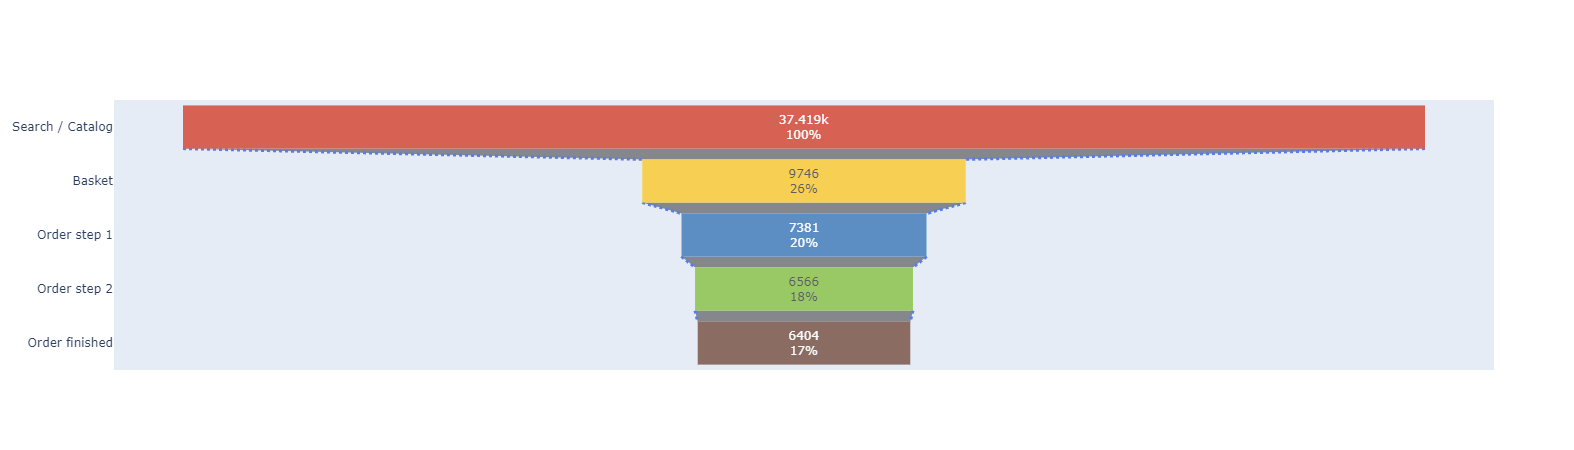

In [62]:
plot_new_funnel(phases, values)

### Пойдем другим путем

In [43]:
q = '''
SELECT
    ClientID,
    groupArray(cast(EventTime as UInt64)) as times,
    groupArray(URL) as urls,
    arrayFilter(time, url -> url in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'), times, urls)[1] as step1_time
FROM
    (SELECT * FROM metrica_data.hits ORDER BY ClientID, EventTime)
GROUP BY ClientID
LIMIT 5
FORMAT TabSeparatedWithNames
'''

my_client.get_clickhouse_df(q)

,ClientID,times,urls,step1_time
0,2773878518280827494,[1593682943],['https://supermarket.ru/promo_action_2068'],0
1,11346328702551058579,"[1594907928,1594907943,1594907962,1594907981,1...","['https://supermarket.ru/product_8046','https:...",0
2,13106442848447404077,"[1600246925,1600246953,1600247004,1600247041,1...","['https://supermarket.ru/login','https://super...",0
3,13041872533683226559,"[1596262807,1596262822]","['https://supermarket.ru/product_1858','https:...",0
4,14051588439054376991,"[1594202050,1594202071]","['https://supermarket.ru/product_1036','https:...",0


In [44]:
q = '''
SELECT
    ClientID,
    groupArray(cast(EventTime as UInt64)) as times,
    groupArray(URL) as urls,
    arrayFilter(time, url -> url in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'), times, urls)[1] as step1_time,
    arrayFilter(time, url -> url = 'https://supermarket.ru/basket' and step1_time != 0 and time >= step1_time, times, urls)[1] as step2_time
FROM
    (SELECT * FROM metrica_data.hits ORDER BY ClientID, EventTime)
GROUP BY ClientID
LIMIT 5
FORMAT TabSeparatedWithNames
'''

my_client.get_clickhouse_df(q)

,ClientID,times,urls,step1_time,step2_time
0,2773878518280827494,[1593682943],['https://supermarket.ru/promo_action_2068'],0,0
1,11346328702551058579,"[1594907928,1594907943,1594907962,1594907981,1...","['https://supermarket.ru/product_8046','https:...",0,0
2,13106442848447404077,"[1600246925,1600246953,1600247004,1600247041,1...","['https://supermarket.ru/login','https://super...",0,0
3,13041872533683226559,"[1596262807,1596262822]","['https://supermarket.ru/product_1858','https:...",0,0
4,14051588439054376991,"[1594202050,1594202071]","['https://supermarket.ru/product_1036','https:...",0,0


In [64]:
q = '''
SELECT
    countIf(step1_time != 0) as step1,
    countIf(step2_time != 0) as step2,
    countIf(step3_time != 0) as step3,
    countIf(step4_time != 0) as step4,
    countIf(step5_time != 0) as step5
FROM
    (SELECT
        ClientID,
        groupArray(cast(EventTime as UInt64)) as times,
        groupArray(URL) as urls,
        arrayFilter(time, url -> url in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'), times, urls)[1] as step1_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/basket' and step1_time != 0 and time >= step1_time, times, urls)[1] as step2_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/order_step_1' and step2_time != 0 and time >= step2_time, times, urls)[1] as step3_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/order_step_2' and step3_time != 0 and time >= step3_time, times, urls)[1] as step4_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/order_step_3' and step4_time != 0 and time >= step4_time, times, urls)[1] as step5_time
    FROM
        (SELECT * FROM metrica_data.hits ORDER BY ClientID, EventTime)
    GROUP BY ClientID)
FORMAT TabSeparatedWithNames
'''

fdf = my_client.get_clickhouse_df(q)

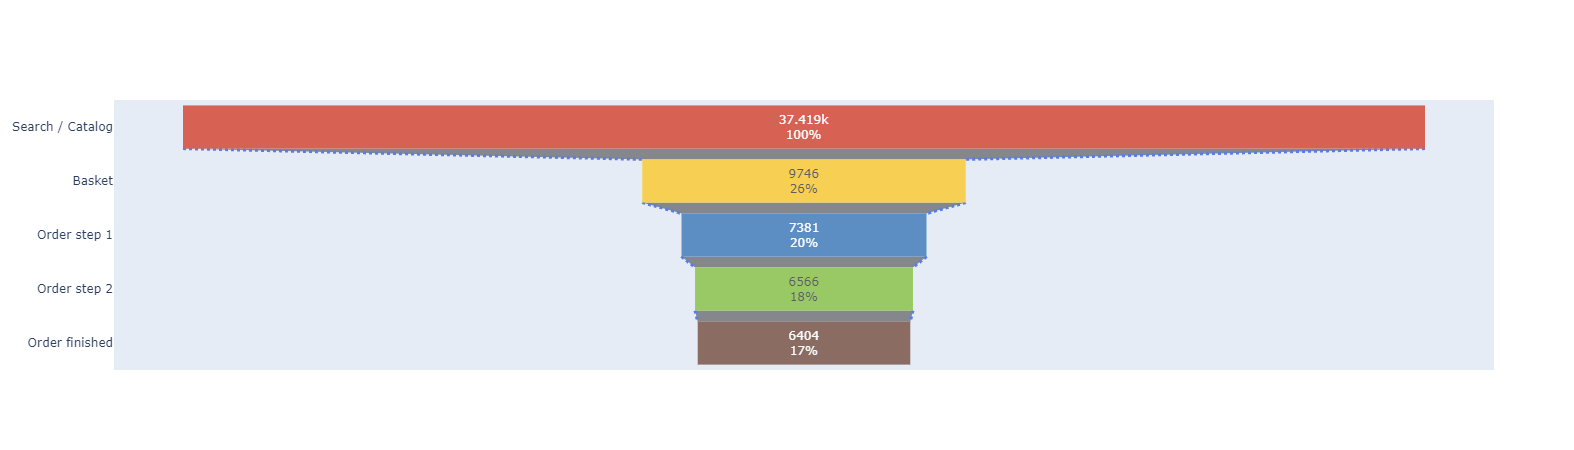

In [65]:
phases = ['Search / Catalog', 'Basket', 'Order step 1', 'Order step 2', 'Order finished']
values = fdf.iloc[0].values

plot_new_funnel(phases, values)

Можем также посчитать среднее время достижения шагов

In [47]:
q = '''
SELECT
    medianIf(step2_time - step1_time, step2_time != 0) as step2_from_step1_mean_time,
    medianIf(step3_time - step2_time, step3_time != 0) as step3_from_step2_mean_time,
    medianIf(step4_time - step3_time, step4_time != 0) as step4_from_step3_mean_time,
    medianIf(step5_time - step4_time, step5_time != 0) as step5_from_step4_mean_time
FROM
    (SELECT
        ClientID,
        groupArray(cast(EventTime as UInt64)) as times,
        groupArray(URL) as urls,
        arrayFilter(time, url -> url in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'), times, urls)[1] as step1_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/basket' and step1_time != 0 and time >= step1_time, times, urls)[1] as step2_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/order_step_1' and step2_time != 0 and time >= step2_time, times, urls)[1] as step3_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/order_step_2' and step3_time != 0 and time >= step3_time, times, urls)[1] as step4_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/order_step_3' and step4_time != 0 and time >= step4_time, times, urls)[1] as step5_time
    FROM
        (SELECT * FROM metrica_data.hits ORDER BY ClientID, EventTime)
    GROUP BY ClientID)
FORMAT TabSeparatedWithNames
'''

my_client.get_clickhouse_df(q)

,step2_from_step1_mean_time,step3_from_step2_mean_time,step4_from_step3_mean_time,step5_from_step4_mean_time
0,1118,675,81,53


### Воронки по браузеру

In [48]:
q = '''
SELECT
    Browser,
    countIf(step1_time != 0) as step1,
    countIf(step2_time != 0) as step2,
    countIf(step3_time != 0) as step3,
    countIf(step4_time != 0) as step4,
    countIf(step5_time != 0) as step5
FROM
(
    SELECT
        Browser,
        ClientID,
        groupArray(cast(EventTime as UInt64)) as times,
        groupArray(URL) as urls,
        arrayFilter(time, url -> url in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'), times, urls)[1] as step1_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/basket' and step1_time != 0 and time >= step1_time, times, urls)[1] as step2_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/order_step_1' and step2_time != 0 and time >= step2_time, times, urls)[1] as step3_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/order_step_2' and step3_time != 0 and time >= step3_time, times, urls)[1] as step4_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/order_step_3' and step4_time != 0 and time >= step4_time, times, urls)[1] as step5_time
    FROM
        (SELECT * FROM metrica_data.hits ORDER BY ClientID, EventTime)
    GROUP BY Browser, ClientID
)
GROUP BY Browser
FORMAT TabSeparatedWithNames
'''

fdf = my_client.get_clickhouse_df(q)

In [49]:
fdf.sort_values('step1', ascending=False).head()

,Browser,step1,step2,step3,step4,step5
27,chrome,12366,3880,3110,2812,2744
47,safari_mobile,4678,902,581,515,502
38,chromemobile,4220,433,197,131,129
46,yandex_browser,4146,1241,956,842,814
10,firefox,2776,1002,797,727,713


In [50]:
my_client.get_clickhouse_data('drop table if exists metrica_data.funnels_by_bro')

q = '''
create table metrica_data.funnels_by_bro Engine = Log as
SELECT
    Browser,
    countIf(step1_time != 0) as step1,
    countIf(step2_time != 0) as step2,
    countIf(step3_time != 0) as step3,
    countIf(step4_time != 0) as step4,
    countIf(step5_time != 0) as step5
FROM
(
    SELECT
        Browser,
        ClientID,
        groupArray(cast(EventTime as UInt64)) as times,
        groupArray(URL) as urls,
        arrayFilter(time, url -> url in ('https://supermarket.ru/catalog', 'https://supermarket.ru/search'), times, urls)[1] as step1_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/basket' and step1_time != 0 and time >= step1_time, times, urls)[1] as step2_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/order_step_1' and step2_time != 0 and time >= step2_time, times, urls)[1] as step3_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/order_step_2' and step3_time != 0 and time >= step3_time, times, urls)[1] as step4_time,
        arrayFilter(time, url -> url = 'https://supermarket.ru/order_step_3' and step4_time != 0 and time >= step4_time, times, urls)[1] as step5_time
    FROM
        (SELECT * FROM metrica_data.hits ORDER BY ClientID, EventTime)
    GROUP BY Browser, ClientID
)
GROUP BY Browser
'''

my_client.get_clickhouse_data(q)

''

### Готово, можно переходить к следующему NoteBook'у `cohorts.ipynb`